# IPP M2DS</a>
# Predicting the France healthcare fees

<i> LAMJOUN Jihane, BONNETIER Isabel, MERRHEIM Maïssane, CREUSILLET Augustin, MESSIN Guerlain, PANTELEICIUC Ion </i>

Introduction : 

The dataset is provided by the french online health insurance : Ameli. Link : https://data.ameli.fr/explore/dataset/honoraires/

The training data contains 37859 lines and the test data contains 9466 lines. The data contains : 
- the year (annee)
- the health_profession (profession_sante)
- the region (region)
- the department (departement)
- fees_without_exceeding_means (hono_sans_depassement_moyens)

The goal is to predict the fees_without_exceeding_means column. The prediction quality is measured by the RMSE.
The challenge in this RAMP is to predict as precisely as possible the fees of medical consultations knowing the year of the consultation, the heal_profession of the doctor, the region and the department of the health appointment. The are a lot of rows in the dataset, therefore the training of the model should lead to qualitative and interesting results. The goal here is to have the best precision score on predicting the fees of medical consultations (fees_without_exceeding_means column).

### Imports

In [41]:
import pandas as pd
import numpy as np
import problem
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

### Load the data

In [9]:
data_file = "./data/train.csv"
df = pd.read_csv(data_file)
df.head()

,annee,profession_sante,region,departement,hono_sans_depassement_moyens
0,2015,Ensemble des médecins spécialistes (hors génér...,53,35,262137
1,2016,Orthoptistes,84,15,50893
2,2021,Sages-femmes,76,34,72474
3,2019,Ophtalmologues,75,24,371491
4,2012,Sages-femmes,24,41,37371


### Data exploration

We look at the dataset, the datatypes and carry out necessary conversions. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37858 entries, 0 to 37857
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   annee                         37858 non-null  int64 
 1   profession_sante              37858 non-null  object
 2   region                        37858 non-null  int64 
 3   departement                   37858 non-null  object
 4   hono_sans_depassement_moyens  37858 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.4+ MB


We have different datatypes: int64 and object.

In [11]:
df.isna().any()

annee                           False
profession_sante                False
region                          False
departement                     False
hono_sans_depassement_moyens    False
dtype: bool

There are no missing values. Let's look at the 'annee' column, we will want to transform the years into datetime data.

In [4]:
df.loc[:, 'annee']

0        2015
1        2016
2        2021
3        2019
4        2012
         ... 
37853    2014
37854    2022
37855    2012
37856    2013
37857    2013
Name: annee, Length: 37858, dtype: int64

In [17]:
# Convert the 'annee' column to datetime format
df.loc[:, 'annee'] = pd.to_datetime(df.loc[:, 'annee'])
# Display the updated information about the DataFrame df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37858 entries, 0 to 37857
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   annee                         37858 non-null  datetime64[ns]
 1   profession_sante              37858 non-null  object        
 2   region                        37858 non-null  int64         
 3   departement                   37858 non-null  object        
 4   hono_sans_depassement_moyens  37858 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 1.4+ MB


We get the data we want to predict through the problem. The model will take a pd.DataFrame as input and output a np.array.

In [29]:
# Get the training data X and y from the problem
X, y = problem.get_train_data()
print("type(X) :",type(X))
print(X.info())
print("type(y) :",type(y))
X.head()

type(X) : <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37858 entries, 0 to 37857
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   annee             37858 non-null  int64 
 1   profession_sante  37858 non-null  object
 2   region            37858 non-null  int64 
 3   departement       37858 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.2+ MB
None
type(y) : <class 'numpy.ndarray'>


,annee,profession_sante,region,departement
0,2015,Ensemble des médecins spécialistes (hors génér...,53,35
1,2016,Orthoptistes,84,15
2,2021,Sages-femmes,76,34
3,2019,Ophtalmologues,75,24
4,2012,Sages-femmes,24,41


In [31]:
print(min(X['annee']))
print(max(X['annee']))
print(X['annee'].unique())

2010
2022
[2015 2016 2021 2019 2012 2020 2022 2017 2018 2011 2010 2013 2014]


In [26]:
# Inspect the y np.array ie the mean fees of medical consultations without exceeding
print(y[:7])

# Calculate mean
mean_y = np.mean(y)
# Calculate standard deviation
std_y = np.std(y)
# Calculate median
median_y = np.median(y)
# Get the number of elements in the array (support)
support_y = len(y)

# Print the calculated statistics
print("Mean:", np.round(mean_y, 0))
print("Standard Deviation:", np.round(std_y,0))
print("Median:", np.round(median_y,0))
print("Support (Number of elements):", support_y)


[262137  50893  72474 371491  37371 144955 182554]
Mean: 193614.0
Standard Deviation: 240161.0
Median: 153346.0
Support (Number of elements): 37858


### Data visualization

<function matplotlib.pyplot.show(close=None, block=None)>

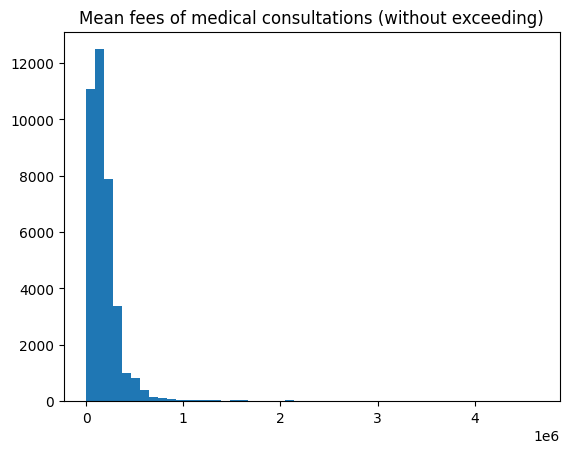

In [32]:
# Histogram of the mean fees of medical consultations (without exceeding)
plt.hist(y, bins=50)
plt.title("Mean fees of medical consultations (without exceeding)")
plt.show

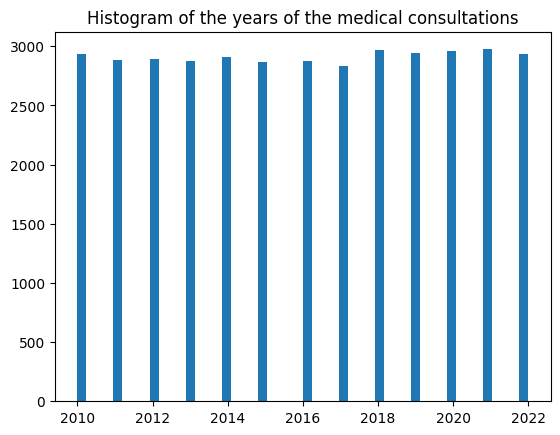

In [34]:
# Histogram of the years of the medical consultations
plt.hist(X['annee'], bins=50)
plt.title('Histogram of the years of the medical consultations')
plt.show()

### Predictor of fees

In [35]:
# Initialize the ordinal encoder
categorical_encoder = OrdinalEncoder()
# Define the list of categorical columns
categorical_cols = ["annee", "profession_sante", "region", "departement"]

In [36]:
# Create a column transformer with the categorical encoder
preprocessor = make_column_transformer(
    (categorical_encoder, categorical_cols),
    remainder='passthrough',  
)

# Initialize a predictor with specified parameters
regressor = RandomForestRegressor(
    n_estimators=10, max_depth=10, max_features=10, n_jobs=4
)

# Create a pipeline by chaining the preprocessor and regressor
pipeline = make_pipeline(preprocessor, regressor)

# Fit the pipeline to the training data (X) and target labels (y)
pipeline.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['annee', 'profession_sante',
                                                   'region',
                                                   'departement'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=10, max_features=10,
                                       n_estimators=10, n_jobs=4))])

In [42]:
# Get the test data from the problem
X_test, y_test = problem.get_test_data()

# Predict the target values for the test data using the pipeline
y_pred = pipeline.predict(X_test)
print(y_pred)

# Compute the root mean squared error (RMSE) between the true and predicted target values
print("RMSE = ",mean_squared_error(y_test, y_pred, squared=False))
# Compute the mean absolute error (MAE) between the true and predicted target values
print("MAE = ", mean_absolute_error(y_test, y_pred))

[ 78738.54421592  73840.78580014   2882.38514815 ... 521978.07447909
  79837.58559796 207794.65683395]
RMSE =  113746.48919785266
MAE =  40808.70800497042


/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
